In [1]:
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')

import copy
import pickle
import numpy as np
from time import time
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
from torch import distributed as dist
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, TensorDataset

from src.utils import *
from src.classifier import Classifier
from src.gan import Generator, Discriminator, DistributionDiscriminator
from src.baselines import risk_minimization, valid_classifier
from src.train_gan import train_gan, generate_dataset_from_gan
from src.data_generator import generate_sequential_datasets

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

# 1. Parameters

In [2]:
# 文件保存
experiment = 2

# 生成数据集
no = 10000
x_dim = 6
seq_len = 10
hiddens = [x_dim + 1, 32, 64, 1]
epsilon = 0.1

# 数据预处理
test_size = 0.2
valid_size = 0.125
batch_size = 512

# Step1: 训练Classifier
c_hiddens = [x_dim + 1, 32, 64, 1]

# Step2: 训练GAN
g_hidden_size = 64
g_num_layers = 2
d_hidden_size = 64
d_num_layers = 2
gan_epochs = 3000

# Step3: 重训练Classifier
dp_lambda = 6

# 使用CPU或GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### 1.1 Save Files

In [3]:
res_path = Path('../res')
log_dir = res_path / f'experiments_{experiment}'
true_path = log_dir / (f"true_model_" + ".pth")
clf_path = log_dir / (f"c_model_" + ".pth")
gan_path = log_dir / (f"gan_model_" + str(gan_epochs) + "_" + str(g_hidden_size) + ".pth")
re_clf_path = log_dir / (f"dp_model-" + str(dp_lambda)+ ".pth")
tsne_path = log_dir / (f"syn-tsne.png")

if not res_path.exists():
    res_path.mkdir()

if not log_dir.exists():
    log_dir.mkdir(parents=True)


# 2. Generate Synthetic Dataset

In [8]:
s0, x, y, gt_model = generate_sequential_datasets(10, x_dim, seq_len, hiddens, epsilon, device, true_path)
gt_model.to(device)

Time:  0.02s


TrueModel(
  (model): Sequential(
    (0): Linear(in_features=7, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Sigmoid()
  )
  (loss_fn): BCELoss()
)

In [10]:
print(x.size)

600


### 2.1 Processing Datasets

In [5]:
# 划分训练集和测试集
s_train, s_test, x_train, x_test, y_train, y_test = train_test_split(s0, x, y, test_size=test_size, random_state=10)
s_train, s_valid, x_train, x_valid, y_train, y_valid = train_test_split(s_train, x_train, y_train, test_size=valid_size, random_state=10)
print(s_train.shape, x_train.shape, y_train.shape)

# 把数据标准化到[0, 1]区间
scalers = [MinMaxScaler() for _ in range(seq_len)]
for i in range(seq_len):
    x_train[:, i] = scalers[i].fit_transform(x_train[:, i])
    x_valid[:, i] = scalers[i].transform(x_valid[:, i])
    x_test[:, i] = scalers[i].transform(x_test[:, i])

# 生成数据生成器
train_data = TensorDataset(tensor(s_train), tensor(x_train), tensor(y_train))
valid_data = TensorDataset(tensor(s_valid), tensor(x_valid),tensor(y_valid))
test_data = TensorDataset(tensor(s_test), tensor(x_test), tensor(y_test))
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=len(valid_data), shuffle=False)
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

(7000, 1) (7000, 10, 6) (7000, 10, 1)


### 2.2 Visualization

In [6]:
data_distance(s_train, x_train[:, 0])
data_distance(s_valid, x_valid[:, 0])
data_distance(s_test, x_test[:, 0])
print(" ")
data_distance(s_train, x_train[:, -1])
data_distance(s_valid, x_valid[:, -1])
data_distance(s_test, x_test[:, -1])

X0-X1-W-dis: tensor(0.2944)
X0-X1-W-dis: tensor(0.3284)
X0-X1-W-dis: tensor(0.3125)
 
X0-X1-W-dis: tensor(0.2862)
X0-X1-W-dis: tensor(0.3174)
X0-X1-W-dis: tensor(0.3010)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.089818
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.565453
[t-SNE] KL divergence after 1000 iterations: 1.005143


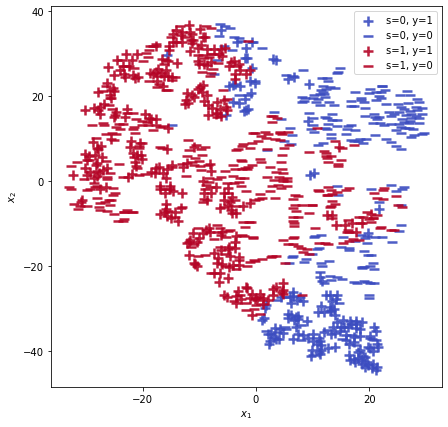

In [7]:
visualize_step_data(s_train, x_train, y_train, step=0)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.080247
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.240818
[t-SNE] KL divergence after 1000 iterations: 0.650886


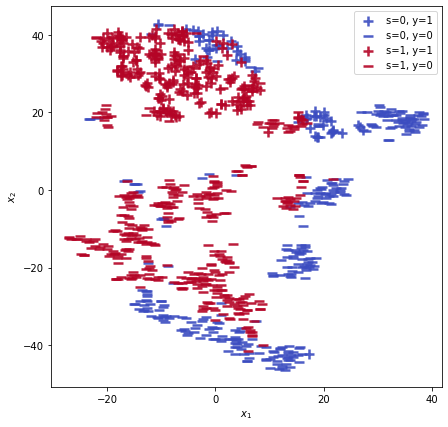

In [8]:
visualize_step_data(s_train, x_train, y_train, step=-1)

# 2. Train Classifier

In [9]:
clf = Classifier(c_hiddens)
clf.to(device)

Classifier(
  (model): Sequential(
    (0): Linear(in_features=7, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Sigmoid()
  )
  (loss_fn): BCELoss()
)

In [10]:
if not clf_path.exists():
    clf.fit(train_loader, valid_loader, clf_path, device)

In [11]:
clf.load_state_dict(torch.load(clf_path, map_location=device))
clf.eval(test_loader, device)

#(S=0): 741, #(S=1): 1259, #(y0): 1131, #(y1): 869, P(y=1|s=0)=0.422, P(y=1|s=1)=0.442
Step:      0, ACC:  83.00%, FAIR:   0.02

#(S=0): 741, #(S=1): 1259, #(y0): 1254, #(y1): 746, P(y=1|s=0)=0.267, P(y=1|s=1)=0.435
Step:      1, ACC:  87.50%, FAIR:   0.17

#(S=0): 741, #(S=1): 1259, #(y0): 1308, #(y1): 692, P(y=1|s=0)=0.224, P(y=1|s=1)=0.418
Step:      2, ACC:  90.65%, FAIR:   0.19

#(S=0): 741, #(S=1): 1259, #(y0): 1316, #(y1): 684, P(y=1|s=0)=0.200, P(y=1|s=1)=0.426
Step:      3, ACC:  90.65%, FAIR:   0.23

#(S=0): 741, #(S=1): 1259, #(y0): 1300, #(y1): 700, P(y=1|s=0)=0.224, P(y=1|s=1)=0.424
Step:      4, ACC:  92.10%, FAIR:   0.20

#(S=0): 741, #(S=1): 1259, #(y0): 1310, #(y1): 690, P(y=1|s=0)=0.219, P(y=1|s=1)=0.419
Step:      5, ACC:  91.55%, FAIR:   0.20

#(S=0): 741, #(S=1): 1259, #(y0): 1313, #(y1): 687, P(y=1|s=0)=0.212, P(y=1|s=1)=0.421
Step:      6, ACC:  92.25%, FAIR:   0.21

#(S=0): 741, #(S=1): 1259, #(y0): 1309, #(y1): 691, P(y=1|s=0)=0.215, P(y=1|s=1)=0.423
Step:     

13.907402217388153

# 3. Train Seq-GAN

In [12]:
generator = Generator(x_dim, g_hidden_size, g_num_layers)
generator.to(device)

Generator(
  (h0_linear): Linear(in_features=6, out_features=64, bias=True)
  (rnn): GRU(9, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=6, bias=True)
  (sigmoid): Sigmoid()
)

In [13]:
discriminator = Discriminator(x_dim, d_hidden_size, d_num_layers)
discriminator.to(device)

Discriminator(
  (rnn): GRU(6, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [14]:
if gan_path.exists():
    generator.load_state_dict(torch.load(gan_path, map_location=device))
else:
    train_gan(train_loader, clf, generator, discriminator, gan_epochs, device)
    torch.save(generator.state_dict(), gan_path)

### 3.1 Genearte Datasets from GAN

In [15]:
gen_train_loader, gen_train_s, gen_train_x, gen_train_y = generate_dataset_from_gan(train_loader, clf, generator, device)
gen_valid_loader, gen_valid_s, gen_valid_x, gen_valid_y = generate_dataset_from_gan(valid_loader, clf, generator, device)
gen_test_loader, gen_test_s, gen_test_x, gen_test_y = generate_dataset_from_gan(test_loader, clf, generator, device)

In [16]:
clf.eval(gen_test_loader, device)

#(S=0): 741, #(S=1): 1259, #(y0): 1131, #(y1): 869, P(y=1|s=0)=0.422, P(y=1|s=1)=0.442
Step:      0, ACC: 100.00%, FAIR:   0.02

#(S=0): 741, #(S=1): 1259, #(y0): 1249, #(y1): 751, P(y=1|s=0)=0.291, P(y=1|s=1)=0.425
Step:      1, ACC: 100.00%, FAIR:   0.13

#(S=0): 741, #(S=1): 1259, #(y0): 1335, #(y1): 665, P(y=1|s=0)=0.209, P(y=1|s=1)=0.405
Step:      2, ACC: 100.00%, FAIR:   0.20

#(S=0): 741, #(S=1): 1259, #(y0): 1317, #(y1): 683, P(y=1|s=0)=0.179, P(y=1|s=1)=0.437
Step:      3, ACC: 100.00%, FAIR:   0.26

#(S=0): 741, #(S=1): 1259, #(y0): 1311, #(y1): 689, P(y=1|s=0)=0.200, P(y=1|s=1)=0.430
Step:      4, ACC: 100.00%, FAIR:   0.23

#(S=0): 741, #(S=1): 1259, #(y0): 1326, #(y1): 674, P(y=1|s=0)=0.179, P(y=1|s=1)=0.430
Step:      5, ACC: 100.00%, FAIR:   0.25

#(S=0): 741, #(S=1): 1259, #(y0): 1337, #(y1): 663, P(y=1|s=0)=0.175, P(y=1|s=1)=0.423
Step:      6, ACC: 100.00%, FAIR:   0.25

#(S=0): 741, #(S=1): 1259, #(y0): 1312, #(y1): 688, P(y=1|s=0)=0.198, P(y=1|s=1)=0.430
Step:     

7.138067498803139

### 3.2 Visualization

In [17]:
data_distance(gen_train_s, gen_train_x[:, 0])
data_distance(gen_valid_s, gen_valid_x[:, 0])
data_distance(gen_test_s, gen_test_x[:, 0])
print("")
data_distance(gen_train_s, gen_train_x[:, -1])
data_distance(gen_valid_s, gen_valid_x[:, -1])
data_distance(gen_test_s, gen_test_x[:, -1])

X0-X1-W-dis: tensor(0.2944)
X0-X1-W-dis: tensor(0.3284)
X0-X1-W-dis: tensor(0.3125)

X0-X1-W-dis: tensor(0.2844)
X0-X1-W-dis: tensor(0.3187)
X0-X1-W-dis: tensor(0.2981)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.089818
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.565460
[t-SNE] KL divergence after 1000 iterations: 1.005143


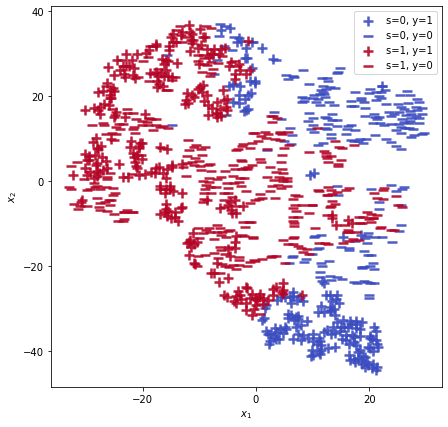

In [18]:
visualize_step_data(gen_train_s, gen_train_x, gen_train_y, step=0)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.088239
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.218658
[t-SNE] KL divergence after 1000 iterations: 0.848633


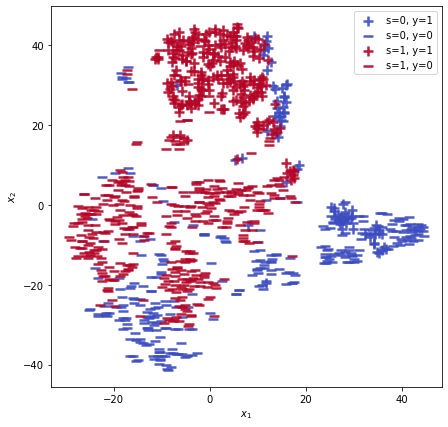

In [19]:
visualize_step_data(gen_train_s, gen_train_x, gen_train_y, step=-1)

Real shape: (250, 10, 6)
Syn shape: (250, 10, 6)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...
[t-SNE] Computed neighbors for 5000 samples in 0.177s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.071678
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.774048
[t-SNE] KL divergence after 1000 iterations: 1.034526


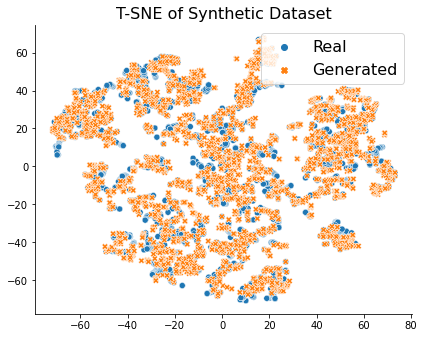

In [20]:
visualization(x_test, gen_test_x[:, 0:10], tsne_path)

# 4. Retrain Classifier

In [21]:
true_model = copy.deepcopy(clf)
re_clf = copy.deepcopy(clf)

In [22]:
risk_minimization(batch_size, seq_len, true_model, re_clf, generator, gen_train_loader, dp_lambda, device, re_clf_path)
re_clf.load_state_dict(torch.load(re_clf_path, map_location=device))

Save
epochs: 1, loss: 164.60199
Save
epochs: 2, loss: 147.88849
Save
epochs: 3, loss: 132.79007
Save
epochs: 4, loss: 120.71438
Save
epochs: 5, loss: 109.91388
Save
epochs: 6, loss: 101.15015
Save
epochs: 7, loss: 94.94820
Save
epochs: 8, loss: 92.64656
Save
epochs: 9, loss: 92.28555
epochs: 10, loss: 96.31990
epochs: 11, loss: 95.16566
epochs: 12, loss: 96.80782
epochs: 13, loss: 92.54907
Save
epochs: 14, loss: 91.97870
Save
epochs: 15, loss: 91.09697
Save
epochs: 16, loss: 89.47530
Save
epochs: 17, loss: 88.23873
Save
epochs: 18, loss: 85.68281
Save
epochs: 19, loss: 84.30006
Save
epochs: 20, loss: 81.44629
epochs: 21, loss: 82.94400
Save
epochs: 22, loss: 78.41250
epochs: 23, loss: 78.89551
epochs: 24, loss: 79.47437
epochs: 25, loss: 78.61403
Save
epochs: 26, loss: 76.43034
epochs: 27, loss: 77.69619
epochs: 28, loss: 76.43293
Save
epochs: 29, loss: 75.90514
epochs: 30, loss: 75.93359
Save
epochs: 31, loss: 75.71850
Save
epochs: 32, loss: 75.60965
epochs: 33, loss: 75.69054
Save
ep

epochs: 290, loss: 63.11387
epochs: 291, loss: 63.52420
epochs: 292, loss: 62.66248
epochs: 293, loss: 61.84750
epochs: 294, loss: 64.84211
epochs: 295, loss: 63.85437
epochs: 296, loss: 63.07207
epochs: 297, loss: 63.08017
epochs: 298, loss: 62.53959
Save
epochs: 299, loss: 61.38249
epochs: 300, loss: 62.58020
epochs: 301, loss: 62.06669
epochs: 302, loss: 61.71014
epochs: 303, loss: 62.68023
epochs: 304, loss: 62.13591
epochs: 305, loss: 63.75132
epochs: 306, loss: 63.55411
epochs: 307, loss: 62.14459
epochs: 308, loss: 63.29146
epochs: 309, loss: 63.90959
epochs: 310, loss: 62.95346
epochs: 311, loss: 63.47916
epochs: 312, loss: 62.62621
epochs: 313, loss: 62.68634
epochs: 314, loss: 63.61219
epochs: 315, loss: 63.32995
epochs: 316, loss: 62.79989
epochs: 317, loss: 62.05182
epochs: 318, loss: 63.25222
epochs: 319, loss: 64.26562
Save
epochs: 320, loss: 61.18988
epochs: 321, loss: 62.04544
epochs: 322, loss: 63.03793
epochs: 323, loss: 63.49003
epochs: 324, loss: 63.50433
epochs: 32

<All keys matched successfully>

In [23]:
valid_classifier(seq_len, true_model, re_clf, generator, gen_valid_loader, device)

Step:     0, ACC:81.600%, DP-Fair: -0.040, Short-Fair:-0.078, Long-Fair:-0.213, W-dist:0.3284
Step:     1, ACC:86.600%, DP-Fair:  0.041, Short-Fair:-0.197, Long-Fair:-0.106, W-dist:0.3098
Step:     2, ACC:84.900%, DP-Fair:  0.005, Short-Fair:-0.208, Long-Fair:-0.073, W-dist:0.3242
Step:     3, ACC:82.800%, DP-Fair:  0.017, Short-Fair:-0.154, Long-Fair: 0.057, W-dist:0.3125
Step:     4, ACC:83.400%, DP-Fair: -0.043, Short-Fair:-0.185, Long-Fair: 0.053, W-dist:0.3167
Step:     5, ACC:81.500%, DP-Fair: -0.040, Short-Fair:-0.170, Long-Fair: 0.076, W-dist:0.3206
Step:     6, ACC:83.700%, DP-Fair: -0.024, Short-Fair:-0.149, Long-Fair: 0.100, W-dist:0.3278
Step:     7, ACC:87.600%, DP-Fair: -0.007, Short-Fair:-0.134, Long-Fair: 0.128, W-dist:0.3289
Step:     8, ACC:86.400%, DP-Fair: -0.001, Short-Fair:-0.170, Long-Fair: 0.105, W-dist:0.3206
Step:     9, ACC:85.200%, DP-Fair:  0.010, Short-Fair:-0.165, Long-Fair: 0.115, W-dist:0.3218
Step:    10, ACC:87.100%, DP-Fair:  0.005, Short-Fair:-0.165

(-0.16455695033073425, 0.11258499843079822)

In [24]:
valid_classifier(seq_len, true_model, re_clf, generator, gen_test_loader, device)

Step:     0, ACC:84.850%, DP-Fair:  0.012, Short-Fair:-0.101, Long-Fair:-0.176, W-dist:0.3125
Step:     1, ACC:86.150%, DP-Fair:  0.085, Short-Fair:-0.161, Long-Fair:-0.046, W-dist:0.2929
Step:     2, ACC:84.800%, DP-Fair:  0.063, Short-Fair:-0.188, Long-Fair:-0.009, W-dist:0.3092
Step:     3, ACC:82.650%, DP-Fair:  0.057, Short-Fair:-0.131, Long-Fair: 0.092, W-dist:0.2937
Step:     4, ACC:82.700%, DP-Fair: -0.020, Short-Fair:-0.186, Long-Fair: 0.064, W-dist:0.2972
Step:     5, ACC:83.050%, DP-Fair:  0.002, Short-Fair:-0.151, Long-Fair: 0.109, W-dist:0.3019
Step:     6, ACC:82.750%, DP-Fair: -0.023, Short-Fair:-0.148, Long-Fair: 0.120, W-dist:0.3117
Step:     7, ACC:83.750%, DP-Fair:  0.004, Short-Fair:-0.162, Long-Fair: 0.125, W-dist:0.3072
Step:     8, ACC:84.300%, DP-Fair:  0.025, Short-Fair:-0.178, Long-Fair: 0.128, W-dist:0.2994
Step:     9, ACC:86.750%, DP-Fair:  0.041, Short-Fair:-0.174, Long-Fair: 0.132, W-dist:0.3039
Step:    10, ACC:85.100%, DP-Fair:  0.038, Short-Fair:-0.182

(-0.18218621611595154, 0.13065121409254177)

### 4.1 Visualization

In [25]:
gen_train_loader, gen_train_s, gen_train_x, gen_train_y = generate_dataset_from_gan(train_loader, re_clf, generator, device)
gen_valid_loader, gen_valid_s, gen_valid_x, gen_valid_y = generate_dataset_from_gan(valid_loader, re_clf, generator, device)
gen_test_loader, gen_test_s, gen_test_x, gen_test_y = generate_dataset_from_gan(test_loader, re_clf, generator, device)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.089818
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.565460
[t-SNE] KL divergence after 1000 iterations: 1.005143


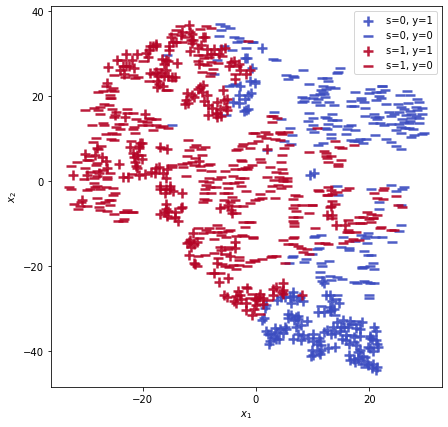

In [26]:
visualize_step_data(gen_train_s, gen_train_x, gen_train_y, step=0)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.028s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.089878
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.390968
[t-SNE] KL divergence after 1000 iterations: 0.821658


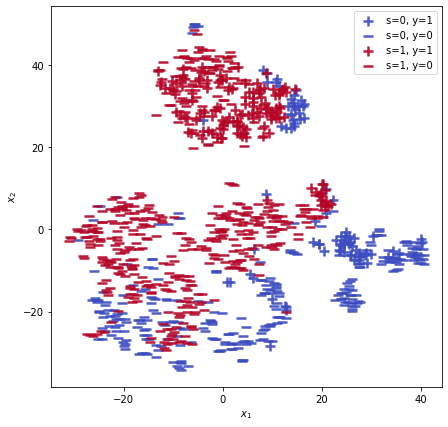

In [27]:
visualize_step_data(gen_train_s, gen_train_x, gen_train_y, step=-1)

In [28]:
data_distance(gen_train_s, gen_train_x[:, 0])
data_distance(gen_valid_s, gen_valid_x[:, 0])
data_distance(gen_test_s, gen_test_x[:, 0])
print("")
data_distance(gen_train_s, gen_train_x[:, -1])
data_distance(gen_valid_s, gen_valid_x[:, -1])
data_distance(gen_test_s, gen_test_x[:, -1])

X0-X1-W-dis: tensor(0.2944)
X0-X1-W-dis: tensor(0.3284)
X0-X1-W-dis: tensor(0.3125)

X0-X1-W-dis: tensor(0.2858)
X0-X1-W-dis: tensor(0.3212)
X0-X1-W-dis: tensor(0.2989)


## Result